In [16]:
import torchvision.datasets

In [25]:
import h5py
import zipfile
import imageio
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [26]:
# mnist_dataset = torchvision.datasets.CelebA(root='D:/py/celeba_data', download=True)

In [18]:
%%time
# location of the HDF5 package, yours may be under /gan/ not /myo_gan/
hdf5_file = 'D:/py/celeba_data/celeba_aligned_small.h5py'

# how many of the 202,599 images to extract and package into HDF5
total_images = 20000

with h5py.File(hdf5_file, 'w') as hf:

    count = 0

    with zipfile.ZipFile('D:/py/celeba_data/img_align_celeba.zip', 'r') as zf:
      for i in zf.namelist():
        if (i[-4:] == '.jpg'):
          # extract image
          ofile = zf.extract(i)
          img = imageio.imread(ofile)
          os.remove(ofile)

          # add image data to HDF5 file with new name
          hf.create_dataset('img_align_celeba/'+str(count)+'.jpg', data=img, compression="gzip", compression_opts=9)
          
          count = count + 1
          if (count%1000 == 0):
            print("images done .. ", count)
            pass
            
          # stop when total_images reached
          if (count == total_images):
            break
          pass

        pass
      pass

images done ..  1000
images done ..  2000
images done ..  3000
images done ..  4000
images done ..  5000
images done ..  6000
images done ..  7000
images done ..  8000
images done ..  9000
images done ..  10000
images done ..  11000
images done ..  12000
images done ..  13000
images done ..  14000
images done ..  15000
images done ..  16000
images done ..  17000
images done ..  18000
images done ..  19000
images done ..  20000
CPU times: total: 2min 41s
Wall time: 3min 1s


In [19]:
# open HDF5 file and list any groups

with h5py.File(hdf5_file, 'r') as file_object:
  
  for group in file_object:
    print(group)
    pass

img_align_celeba


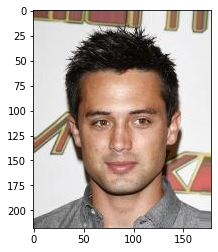

In [21]:
# open HDF5 file and list any groups

with h5py.File(hdf5_file, 'r') as file_object:
  dataset = file_object['img_align_celeba']
  image = numpy.array(dataset['6.jpg'])
  plt.imshow(image, interpolation='none')
  pass

In [22]:
image.shape

(218, 178, 3)

In [24]:
#使用cuda
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: NVIDIA GeForce GTX 1650


device(type='cuda')

In [34]:
#数据集
class CelebADataset(Dataset):
    #打开hdf5,并打开img_align_,以便逐个读取图像
    def __init__(self,file):
        self.file_object=h5py.File(file,'r')
        self.dataset=self.file_object['img_align_celeba']
        pass
    #获取数据集数量
    def __len__(self):
        return len(self.dataset)
    #通过索引转换成图像文件名来检索图像数据
    def __getitem__(self, index):
        #如果索引>=数据集大小，抛出异常
        if (index>=len(self.dataset)):
            raise IndexError()
        img=numpy.array(self.dataset[str(index)+'.jpg'])
        #同样标准化0-1
        return torch.cuda.FloatTensor(img)/255.0
    def plot_image(self,index):
        plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
        pass
    pass

        

In [35]:
# create Dataset object
celeba_dataset = CelebADataset(hdf5_file)

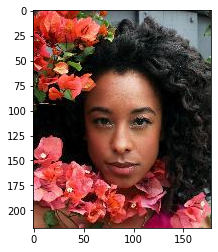

In [36]:
#检查数据图像
celeba_dataset.plot_image(43)

In [37]:
# functions to generate random data
#均匀抽取_鉴别器
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

#正态抽取,均值为0，方差为1，分类器
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [38]:
# modified from https://github.com/pytorch/vision/issues/720
#将三维图像张量重塑成一个长度为218*178*3的一维张量
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [39]:
#鉴别器
class Discriminator(nn.Module):
    def __init__(self):
        #初始化父类
        super().__init__()
        self.model=nn.Sequential(
            #彩色像素--红绿蓝 218*178*3
            View(218*178*3),
            nn.Linear(218*178*3,100),
            nn.LeakyReLU(),
            nn.LayerNorm(100),
            nn.Linear(100,1),
            nn.Sigmoid()
        )
        #loss
        self.loss_function=nn.BCELoss()
        #优化器
        self.optimiser=torch.optim.Adam(self.parameters(),lr=0.0001)
        #计数器&progress
        self.counter=0
        self.progress=[]
        pass
    #调用模型
    def forward(self,inputs):
        return self.model(inputs)
    #训练模型
    def train(self,inputs,targets):
        #计算网络输出
        outputs=self.forward(inputs)
        #计算损失值
        loss=self.loss_function(outputs,targets)
        #10次增加计数器
        self.counter+=1
        if (self.counter%10==0):
            self.progress.append(loss.item())
            pass
        if(self.counter%1000==0):
            print('counter=',self.counter)
            pass
        #归零梯度，反向传播，更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    #绘图
    def plot_progress(self):
        df=pd.DataFrame(self.progress,columns=['loss']) #损失值转换为DF
        df.plot(ylim=(0),figsize=(16,8),alpha=0.1,marker='.',grid=True,yticks=(0,0.25,0.5,1.0,5.0))
        pass

counter= 1000
counter= 2000
counter= 3000
counter= 4000
counter= 5000
counter= 6000
counter= 7000
counter= 8000
counter= 9000
counter= 10000
counter= 11000
counter= 12000
counter= 13000
counter= 14000
counter= 15000
counter= 16000
counter= 17000
counter= 18000
counter= 19000
counter= 20000
counter= 21000
counter= 22000
counter= 23000
counter= 24000
counter= 25000
counter= 26000
counter= 27000
counter= 28000
counter= 29000
counter= 30000
counter= 31000
counter= 32000
counter= 33000
counter= 34000
counter= 35000
counter= 36000
counter= 37000
counter= 38000
counter= 39000
counter= 40000
CPU times: total: 32min 9s
Wall time: 8min 13s


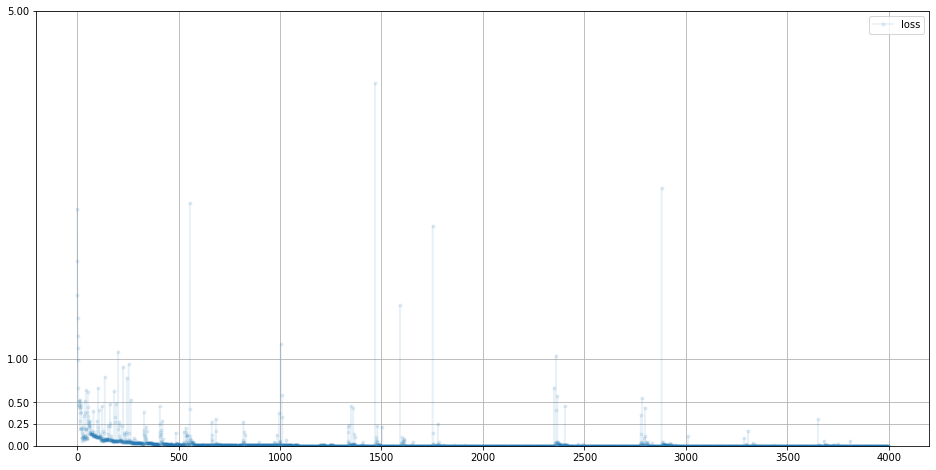

In [41]:
%%time
#训练
D=Discriminator()
#使用cuda
D.to(device)
for image_data_tensor in celeba_dataset:
    #真实
    D.train(image_data_tensor,torch.cuda.FloatTensor([1.0]))
    #伪
    D.train(generate_random_image(218*178*3),torch.cuda.FloatTensor([0.0]))
    pass
D.plot_progress()
    

In [42]:
# 检验鉴别器是否能够很好鉴别

for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image(218*178*3) ).item() )
  pass

0.9997705817222595
0.999941349029541
0.9994194507598877
0.9999288320541382
0.00022293119400274009
0.00022554361203219742
0.00022574928880203515
0.000223449373152107


In [43]:
#生成器
class Generator(nn.Module):
    def __init__(self):
        #初始化父类
        super().__init__()
        #定义网络层
        self.model=nn.Sequential(
            nn.Linear(100,3*10*10),
            nn.LeakyReLU(),
            nn.LayerNorm(3*10*10),
            nn.Linear(3*10*10,3*218*178),
            nn.Sigmoid(),
            View((218,178,3)) #重塑成三维张量
        )
        #优化器
        self.optimiser=torch.optim.Adam(self.parameters(),lr=0.0001)
        #计数器&progress
        self.counter=0
        self.progress=[]
        pass
    #调用模型
    def forward(self,inputs):
        return self.model(inputs)
    #训练模型
    def train(self,D,inputs,targets):
        #计算网络输出
        g_output=self.forward(inputs)
        #输入鉴别器
        d_output=D.forward(g_output)
        #计算损失值
        loss=D.loss_function(d_output,targets)
        #10次增加计数器
        self.counter+=1
        if (self.counter%10==0):
            self.progress.append(loss.item())
            pass
        #归零梯度，反向传播，更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    #绘图
    def plot_progress(self):
        df=pd.DataFrame(self.progress,columns=['loss']) #损失值转换为DF
        df.plot(ylim=(0),figsize=(16,8),alpha=0.1,marker='.',grid=True,yticks=(0,0.25,0.5,1.0,5.0))
        pass

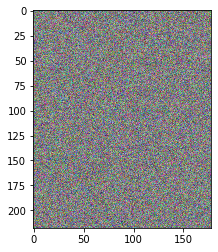

In [44]:
G=Generator()
#cuda
G.to(device)

output=G.forward(generate_random_seed(100))
img=output.detach().cpu().numpy()
plt.imshow(img,interpolation='none',cmap='Blues')

In [45]:
%%time

#训练GAN
D=Discriminator()
#cuda
D.to(device)
G=Generator()
#cuda
G.to(device)

epochs=1
for epoch in range(epochs):
    print ("epoch = ", epoch + 1)
    # image_list=[]
    #训练鉴别器&生成器
    for image_data_tensor in celeba_dataset:
        #真实样本训练鉴别器
        D.train(image_data_tensor,torch.cuda.FloatTensor([1.0]))
        #生成样本训练鉴别器
        #使用detach()避免计算生成器G中的梯度:节省计算成本
        D.train(G.forward(generate_random_seed(100)).detach(),torch.cuda.FloatTensor([0.0]))
        #训练生成器
        G.train(D,generate_random_seed(100),torch.cuda.FloatTensor([1.0]))
        # #每10000次记录图像
        # if (i%1000==0):
        #     image_list.append(G.forward(generate_random(1)).detach().numpy())
        pass
    pass






epoch =  1
counter= 1000
counter= 2000
counter= 3000
counter= 4000
counter= 5000
counter= 6000
counter= 7000
counter= 8000
counter= 9000
counter= 10000
counter= 11000
counter= 12000
counter= 13000
counter= 14000
counter= 15000
counter= 16000
counter= 17000
counter= 18000
counter= 19000
counter= 20000
counter= 21000
counter= 22000
counter= 23000
counter= 24000
counter= 25000
counter= 26000
counter= 27000
counter= 28000
counter= 29000
counter= 30000
counter= 31000
counter= 32000
counter= 33000
counter= 34000
counter= 35000
counter= 36000
counter= 37000
counter= 38000
counter= 39000
counter= 40000
CPU times: total: 1h 23min 34s
Wall time: 21min 5s


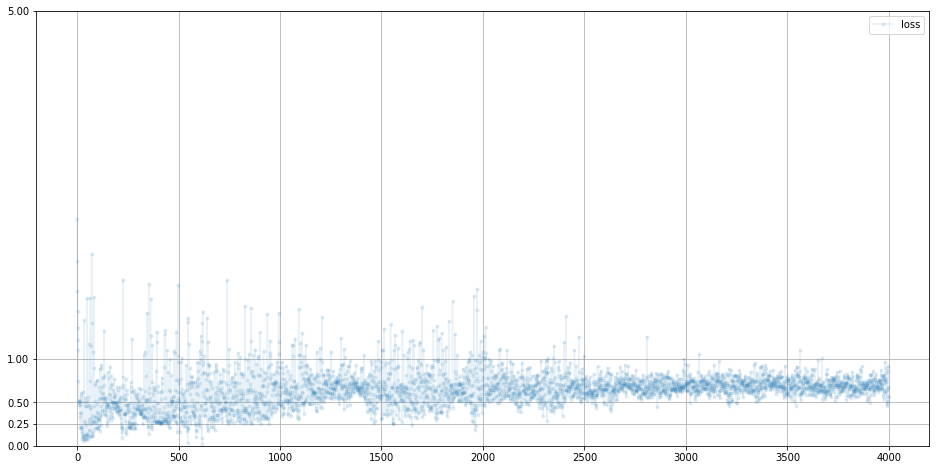

In [46]:
D.plot_progress()

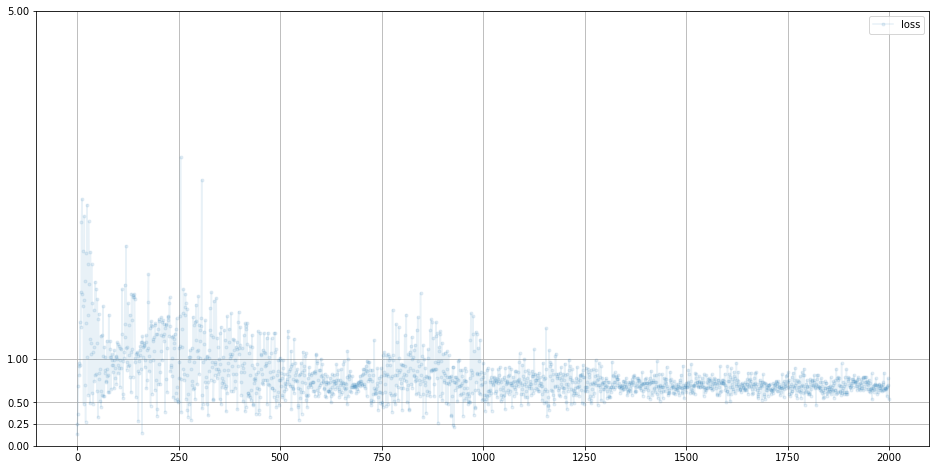

In [47]:
#0.693趋于稳定
G.plot_progress()

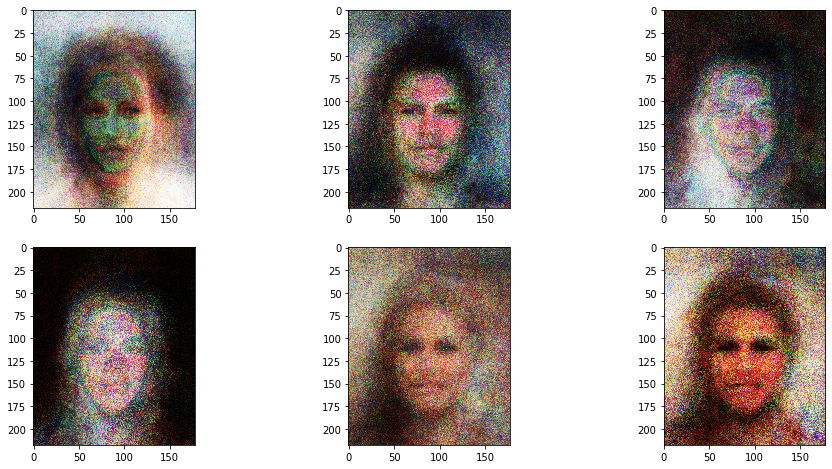

In [49]:
f,axarr=plt.subplots(2,3,figsize=(16,8))
for i in range(2):
    for j in range(3):
        output=G.forward(generate_random_seed(100))
        img=output.detach().cpu().numpy()
        axarr[i,j].imshow(img,interpolation='none',cmap='Blues')
        pass
    pass

In [50]:
#查看自己的内存消耗
torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.6999893188476562

In [51]:
#运行中最大分配
torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

1.093554973602295

In [52]:
#内存消耗汇总
print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  733992 KB |    1119 MB |   19249 GB |   19248 GB |
|---------------------------------------------------------------------------|
| Active memory         |  733992 KB |    1119 MB |   19249 GB |   19248 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |    1220 MB |    1220 MB |    1220 MB |       0 B  |
|---------------------------------------------------------------